In [16]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt


mp.verbosity(0)


0

In [17]:
a = 0.775
r,h,wl, = 0.315*a,0.3,1.55
x_num,y_num = 20,6
wg_wight = y_num*np.sqrt(3)*a*2

kpoint = mp.Vector3(1,0,0)


block_x,block_y,block_z=0,0,0
Block_x,Block_y,Block_z=x_num*a,wg_wight,h

x_length = 3 
y_length = np.sqrt(3)*a
z_length = h

block_x1= -x_num*0.5*a-x_length*0.5
block_x2= -block_x1

aa=4
resolution = 10  # pixels/um

dpml = 1.0
pml_layers = [mp.PML(dpml)]

sx = Block_x + 2 * x_length + 2*aa + 2*dpml  # size of cell in X direction
sy = Block_y + 2*dpml  # size of cell in Y direction
sz = 2*dpml + 5*h
cell = mp.Vector3(sx, sy, sz)

nfreq = 100  # number of frequencies at which to compute flux
fcen = 1/wl  # pulse center frequency
df = 0.1  # pulse width (in frequency)

source_center=mp.Vector3(-sx/2+2, 0, 0)
refl_monitor=mp.Vector3(block_x+aa-Block_x/2 - 1,0,0)
trans_monitor=mp.Vector3(sx/2-dpml-1,0,0)

source_size=mp.Vector3(0, 2*y_length, 3*h)


def lno(a):
    b = 1+2.6734*a**2/(a**2-0.01764)+1.2290*a**2/(a**2-0.0591)+12.614*a**2/(a**2-474.60)
    return b
def lne(a):
    b = 1+2.9804*a**2/(a**2-0.02047)+0.5981*a**2/(a**2-0.0666)+8.9543*a**2/(a**2-416.08)
    return b


def add_cylinder(local):
    a = mp.Cylinder(radius=r,height=h,center=local,material=mp.air)
    return a


LN = mp.Medium(epsilon_diag=(lno(wl),lne(wl),lno(wl)))




<Axes: xlabel='X', ylabel='Y'>

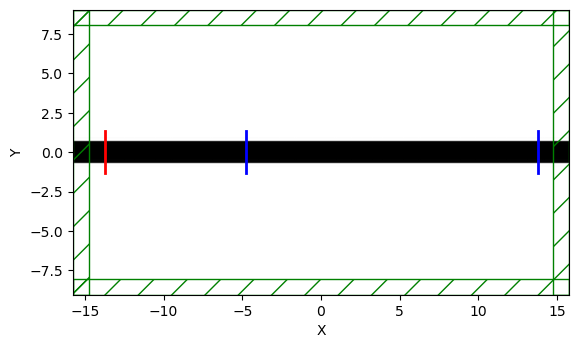

In [18]:
geometry = [
    mp.Block(
        size=mp.Vector3(mp.inf, y_length, z_length),
        center=mp.Vector3(0, 0, 0),
        material=LN,
    )
]


# sources = [
#     mp.Source(
#         mp.GaussianSource(fcen, fwidth=df),
#         component=mp.Ez,
#         center=source_center,
#         size=source_size,
#     )
# ]

src = mp.GaussianSource(frequency=fcen,fwidth=df)
sources = [mp.EigenModeSource(src,
                    eig_band = 1,
                    direction=mp.AUTOMATIC,
                    eig_kpoint=kpoint,
                    size = source_size,
                    center=source_center,
                    ),
                    
                    ]

sim = mp.Simulation(
    cell_size=cell,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=sources,
    resolution=resolution,
    default_material=mp.air,
)


refl_fr = mp.FluxRegion(
    center=refl_monitor, size=source_size
)

# reflected flux
refl = sim.add_flux(fcen, df, nfreq, refl_fr)

tran_fr = mp.FluxRegion(
    center=trans_monitor, size=source_size
)
tran = sim.add_flux(fcen, df, nfreq, tran_fr)

sim.plot2D(output_plane=mp.Volume(center=mp.Vector3(), size=mp.Vector3(sx,sy)))

In [19]:
#pt = mp.Vector3(0.5 * sx - dpml - 0.5, wvg_ycen)

sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ey, trans_monitor, 1e-9))

# for normalization run, save flux fields data for reflection plane
straight_refl_data = sim.get_flux_data(refl)

# save incident power for transmission plane
straight_tran_flux = mp.get_fluxes(tran)

<Axes: xlabel='X', ylabel='Y'>

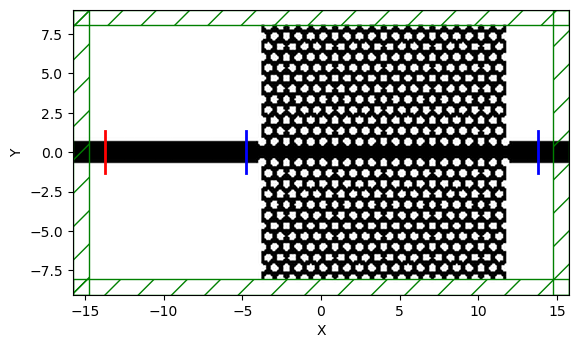

In [20]:
sim.reset_meep()


#############################################



geometry = [mp.Block(size=mp.Vector3(mp.inf,y_length, z_length),
                       center=mp.Vector3(block_x1,0),material=LN),]

geometry += [mp.Block(size=mp.Vector3(Block_x,Block_y, z_length),
                     center=mp.Vector3(block_x+aa,block_y),material=LN)]

for i in np.linspace(-x_num*0.5*a,x_num*0.5*a,x_num+1):
    for j in np.linspace(-y_num*np.sqrt(3)*a,y_num*np.sqrt(3)*a,2*y_num+1):
        if j != 0:
            geometry += [add_cylinder(mp.Vector3(i+0.5*a+aa,j,0)),
                         add_cylinder(mp.Vector3(i+aa,j+np.sqrt(3)*0.5*a,0))]
        else:
            geometry += [add_cylinder(mp.Vector3(i+aa,np.sqrt(3)*0.5*a,0))]


# sources = [
#     mp.Source(
#         mp.GaussianSource(fcen, fwidth=df),
#         component=mp.Ez,
#         center=source_center,
#         size=source_size,
#     )
# ]

src = mp.GaussianSource(frequency=fcen,fwidth=df)
sources = [mp.EigenModeSource(src,
                    eig_band = 1,
                    direction=mp.AUTOMATIC,
                    eig_kpoint=kpoint,
                    size = source_size,
                    center=source_center,
                    ),
                    
                    ]

########################################################

sim = mp.Simulation(
    cell_size=cell,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=sources,
    resolution=resolution,
    default_material=mp.air,
)

refl_fr = mp.FluxRegion(
    center=refl_monitor, size=source_size
)

refl = sim.add_flux(fcen, df, nfreq, refl_fr)

tran_fr = mp.FluxRegion(
    center=trans_monitor, size=source_size
)
tran = sim.add_flux(fcen, df, nfreq, tran_fr)

sim.plot2D(output_plane=mp.Volume(center=mp.Vector3(), size=mp.Vector3(sx,sy)))

In [21]:
# for normal run, load negated fields to subtract incident from refl. fields
sim.load_minus_flux_data(refl, straight_refl_data)

#pt = mp.Vector3(wvg_xcen, 0.5 * sy - dpml - 0.5)

sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ey, trans_monitor, 1e-9))

bend_refl_flux = mp.get_fluxes(refl)
bend_tran_flux = mp.get_fluxes(tran)

flux_freqs = mp.get_flux_freqs(refl)


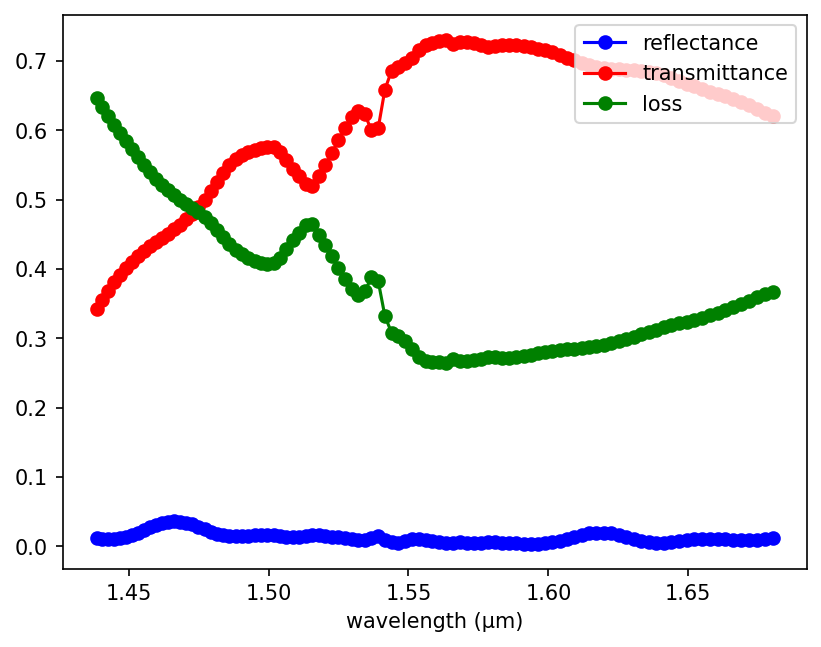

In [23]:
wl = []
Rs = []
Ts = []
for i in range(nfreq):
    wl = np.append(wl, 1 / flux_freqs[i])
    Rs = np.append(Rs, -bend_refl_flux[i] / straight_tran_flux[i])
    Ts = np.append(Ts, bend_tran_flux[i] / straight_tran_flux[i])

plt.figure(dpi=150)
plt.plot(wl, Rs, "bo-", label="reflectance")
plt.plot(wl, Ts, "ro-", label="transmittance")
plt.plot(wl, 1 - Rs - Ts, "go-", label="loss")
plt.xlabel("wavelength (μm)")
plt.legend(loc="upper right")
plt.show()

In [28]:
aaa=np.array(Rs)
aaa

array([0.01227745, 0.01084276, 0.0093912 , 0.00880933, 0.00866135,
       0.00911574, 0.00981338, 0.01041983, 0.01076543, 0.01048434,
       0.00970749, 0.0083974 , 0.00693776, 0.0056084 , 0.00482692,
       0.00487574, 0.00589917, 0.00787578, 0.0105264 , 0.01350455,
       0.0162981 , 0.0184953 , 0.01971857, 0.01979088, 0.01870185,
       0.01662889, 0.01389834, 0.01091147, 0.00809695, 0.00578579,
       0.00422289, 0.0034388 , 0.00336619, 0.00376969, 0.00439589,
       0.00498577, 0.00533801, 0.00550645, 0.00551587, 0.00524655,
       0.00505038, 0.00511472, 0.00566647, 0.00469951, 0.00462482,
       0.00548543, 0.0076672 , 0.00871687, 0.00986954, 0.0105085 ,
       0.00709205, 0.00533189, 0.00574061, 0.00876589, 0.0141017 ,
       0.01188785, 0.00877003, 0.00912433, 0.01012528, 0.01152071,
       0.01291696, 0.01357359, 0.0145074 , 0.01591831, 0.01594857,
       0.01425814, 0.01345811, 0.01331354, 0.01344265, 0.01424947,
       0.0155591 , 0.01649721, 0.01671796, 0.01634169, 0.01530

In [24]:
# For visualization

src = mp.ContinuousSource(frequency=1/1.55, fwidth=df)
source = [
    mp.EigenModeSource(
        src,
        eig_band=1,
        direction=mp.AUTOMATIC,
        eig_kpoint=kpoint,
        size=source_size,
        center=source_center,
    )
]

sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=source,
                    #symmetries=[mp.Mirror(direction=mp.Y)],
                    default_material=mp.air,
                    resolution=resolution)

sim.run(until=200)

FloatProgress(value=0.0, description='0% done ', max=200.0)

<Axes: xlabel='X', ylabel='Y'>

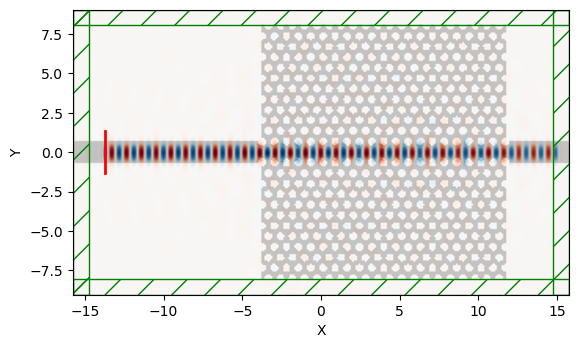

In [25]:
sim.plot2D(fields= mp.Ey,
    output_plane = mp.Volume(
        center = mp.Vector3(z=0.0),
        size = mp.Vector3(x=sx,y=sy)
    ))

/home/satadrudas/anaconda3/envs/meep/lib/python3.11/site-packages/meep/visualization.py:271: UserWarning: The specified user volume is larger than the simulation domain and has been truncated.
  warnings.warn(


<Axes: xlabel='X', ylabel='Z'>

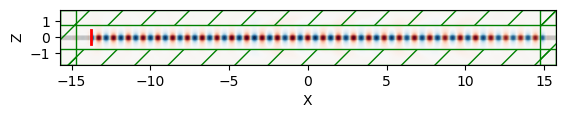

In [26]:
sim.plot2D(fields= mp.Ey,
    output_plane = mp.Volume(
        center = mp.Vector3(),
        size = mp.Vector3(x=sx,z=sy)))

<Axes: xlabel='Y', ylabel='Z'>

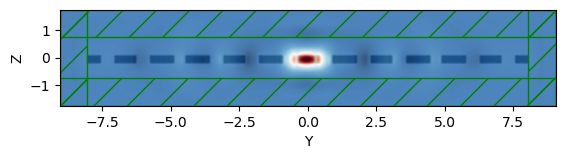

In [27]:
sim.plot2D(fields= mp.Ey,
    output_plane = mp.Volume(
        center = mp.Vector3(x=4),
        size = mp.Vector3(y=sy, z=sz)
    ))